This notebook illustrates the process to create task-embedded training sets across a set of tasks.  For this notebook a task is predicting the y values for a given equation and set of x values.  In addition, a model is trained on these tasks.  Finally, the model is asked to infer y-values for tasks it has been taught and a task it has not been taught.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset

A simple fully connected network is used for training.

In [2]:
class Net(nn.Module):
    def __init__(self, hidden_one):
        super(Net, self).__init__()
        input_size = 10
        self.hidden_one = hidden_one
        output_size = 1

        self.fc1 = nn.Linear(input_size, hidden_one)
        self.fc2 = nn.Linear(hidden_one, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

A custom Dataset is used to perform a transformation on the data.

In [3]:
class shared_task_ds(Dataset):
  def __init__(self, data, targets):
      self.data = data
      self.targets = targets

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.data[idx].unsqueeze(0),self.targets[idx])

The model is trained in batches using a mean squared error loss function.

In [4]:
def train(model, device, train_loader, optimizer, epoch, losses):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # shape [batch,1,9] [[[ 0, 0, ...]]]; shape [batch,1,1] [[[0,0,...]]]
        optimizer.zero_grad()
        output = model(data) # shape [batch,1,1]
        criteria = nn.MSELoss()
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

The function below generates random equations.  A couple equations are forced to be in the set and a one is forced to be left out of the set.

In [5]:
def generate_equation_list(equation_count):
    
    equation_string_encoding_list = []
    
    # Adding known sets
    equation = '-8*(x+1)*(x-4)+9'
    algo_encoding = [1, 8, 1, 2, 1, 1, 4, 2, 9, -1]
    equation_string_encoding_list.append([equation, algo_encoding])

    equation = '+5*(x-4)+9'
    algo_encoding = [2, 5, 2, 0, 0, 1, 4, 2, 9, -1]
    equation_string_encoding_list.append([equation, algo_encoding])

    # Preventing a test equation
    equation_avoid = '+6*(x+9)*(x+5)-3'

    for count in range(equation_count):

        equation = ''
        algo_encoding = []

        if random.randint(1,2) == 1:
            algo_encoding.append(1)
            equation = '-' + equation
        else:
            algo_encoding.append(2)
            equation = '+' + equation

        r = random.randint(1,9)
        algo_encoding.append(r)
        equation = equation + str(r)

        if random.randint(1,2) == 1:
            algo_encoding.append(1)
            equation = equation + '*(x' 
            if random.randint(1,2) == 1:
                algo_encoding.append(1)
                equation = equation + '-'
            else:
                algo_encoding.append(2)
                equation = equation + '+'
            r = random.randint(1,9)
            algo_encoding.append(r)
            equation = equation + str(r) + ')'
        else:
            algo_encoding.append(2)
            algo_encoding.append(0)
            algo_encoding.append(0)

        equation = equation + '*(x' 
        if random.randint(1,2) == 1:
            algo_encoding.append(1)
            equation = equation + '-'
        else:
            algo_encoding.append(2)
            equation = equation + '+'
        r = random.randint(1,9)
        algo_encoding.append(r)
        equation = equation + str(r) + ')'

        if random.randint(1,2) == 1:
            algo_encoding.append(1)
            equation = equation + '-'
        else:
            algo_encoding.append(2)
            equation = equation + '+'
        
        r = random.randint(1,9)
        algo_encoding.append(r)
        equation = equation + str(r)

        length = len(equation)

        for count in range(16 - length):
            equation = equation + ' '

        # Placeholder for the x value
        algo_encoding.append(-1)

        if equation != equation_avoid:
            equation_string_encoding_list.append([equation,algo_encoding])

    return equation_string_encoding_list

For each of the encoded equations created above, a set of x and y points are generated.  The x-value is appended to the equation encoding.  The result is a set of (x-embedded, y) that spans a range of x values and a set of equations.  This set is used for training and test.

In [6]:
def build_set(equation_string_encoding_list, set_eq_x, set_y, size):
    
    for equation in equation_string_encoding_list:
        equation_string = equation[0]
        equation_encoding = equation[1]
        equation_encoded_numpy = np.array(equation_encoding)
        for count in range(size):
            embedded_equation_new = np.copy(equation_encoded_numpy)
            x = random.random() * 20 - 10 # gives an x-value between -10 and 10
            y = eval(equation_string)
            embedded_equation_new[9] = x
            # embedded_equation_new = embedded_equation_new/np.linalg.norm(embedded_equation_new)
            set_eq_x.append(embedded_equation_new)
            set_y.append(y)

The function below tests the model on a given equation for a set of x values.

In [7]:
def test(equation_string, equation_encoding, model, x_values, y_actual, y_pred, size):
    model.eval()

    equation_encoded_numpy = np.array(equation_encoding)
    
    for count in range(size):
        embedded_equation_new = np.copy(equation_encoded_numpy)
        x = random.random() * 20 - 10 # gives an x-value between -10 and 10
        y = eval(equation_string)
        embedded_equation_new[9] = x
        x_values.append(x)
        y_actual.append(y)

        with torch.no_grad():
            embedded_equation_new = torch.tensor(embedded_equation_new, dtype=float).float()
            output = model(embedded_equation_new) # shape [1,1,1]
            y_pred.append(output.item())

The function below generates the data set and saves it as a file.  It is configured to create 400 equations with 2000 data points each.

In [8]:
def main_makedataset():
    print('Dataset Generation Started')
    equation_count = 400
    data_point_per_equation = 2000

    equation_string_encoding_list = generate_equation_list(equation_count)

    training_set_eq_x = []
    training_set_y = []
    test_set_eq_x = []
    test_set_y = []

    build_set(equation_string_encoding_list, training_set_eq_x, training_set_y, data_point_per_equation)
    build_set(equation_string_encoding_list, test_set_eq_x, test_set_y, data_point_per_equation)

    training_set_eq_x = torch.tensor(training_set_eq_x, dtype=float).float()
    training_set_y = torch.tensor(training_set_y, dtype=float).float().unsqueeze(1).unsqueeze(1)

    dataset_train = shared_task_ds(training_set_eq_x,training_set_y)
    
    with open('training_set','wb') as training_file:
        torch.save(dataset_train, training_file)

    print('Dataset Generation Complete')

The function below trains the model using an Adam optimizer with a learning rate of 0.01 for batches of size 16 and a model with a width of 100 nodes across 2 epochs.  The model is tested on two equations in the data set and one that is not.

In [13]:
def main_learn():

    print('Training Run Started')
    
    # Hyperparameters
    learning_rate = 0.01
    epochs = 2
    batch_size = 16
    hidden_nodes = 100

    kwargs = {'batch_size': batch_size}

    filename = 'training_set'
    infile = open(filename,'rb')
    dataset1 = torch.load(infile)

    train_loader = torch.utils.data.DataLoader(dataset1, **kwargs, drop_last=True, shuffle=True)
    device = 'cpu'

    model = Net(hidden_nodes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses)

    x_values1 = []
    x_values2 = []
    x_values3 = []

    y_actual1 = []
    y_actual2 = []
    y_actual3 = []

    y_pred1 = []
    y_pred2 = []
    y_pred3 = []

    size = 60

    equation_string = '-8*(x+1)*(x-4)+9'
    equation_encoding = [1, 8, 1, 2, 1, 1, 4, 2, 9, -1]
    test(equation_string, equation_encoding, model, x_values1, y_actual1, y_pred1, size)

    
    equation_string = '+5*(x-4)+9'
    equation_encoding = [2, 5, 2, 0, 0, 1, 4, 2, 9, -1]
    test(equation_string, equation_encoding, model, x_values2, y_actual2, y_pred2, size)

    # Test on equation not in training set
    equation_string = '+6*(x+9)*(x+5)-3'
    equation_encoding = [2, 6, 1, 2, 9, 2, 5, 1, 3, -1]
    test(equation_string, equation_encoding, model, x_values3, y_actual3, y_pred3, size)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Test Equations')
    ax1.set_title('In Set')
    ax2.set_title('In Set')
    ax3.set_title('Out of Set')
    ax1.scatter(x_values1, y_actual1)
    ax1.scatter(x_values1, y_pred1)
    ax2.scatter(x_values2, y_actual2)
    ax2.scatter(x_values2, y_pred2)
    ax3.scatter(x_values3, y_actual3)
    ax3.scatter(x_values3, y_pred3)
    ax1.legend(['Actual','Predicted'])
    ax2.legend(['Actual','Predicted'])
    ax3.legend(['Actual','Predicted'])
    # experiment.log_figure(figure=plt)
    plt.show()
    plt.close()

    print('Training Run Complete')

As shown below, the model is able to predict y values when x-values are embedded with the task (i.e. the equation encoding) even when the model has never seen an equation.

Dataset Generation Started
Dataset Generation Complete
Training Run Started


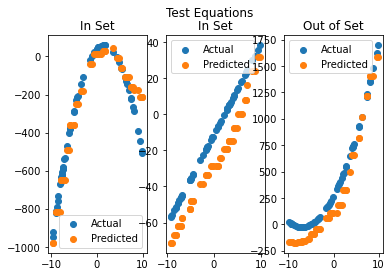

Training Run Complete


In [14]:
main_makedataset()
main_learn()